# EDA of DELAYS #

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.subplots as sp
from plotly.subplots import make_subplots
import warnings 
warnings.filterwarnings('ignore')

# To get graphs from library go on github:
import plotly.io as pio
from PIL import Image

In [3]:
delay_df = pd.read_excel('get_around_delay_analysis.xlsx',sheet_name='rentals_data')
delay_df.head()

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
0,532240,379042,mobile,ended,71084.0,NaN,NaN
1,549980,402829,mobile,ended,64059.0,NaN,NaN
2,537546,408750,mobile,ended,37382.0,NaN,NaN
3,534699,270195,mobile,ended,23126.0,NaN,NaN
4,556557,413591,mobile,ended,22618.0,NaN,NaN


In [3]:
delay_doc = pd.read_excel('get_around_delay_analysis.xlsx',sheet_name='Documentation')
pd.set_option('display.max_colwidth',None)
display(delay_doc)

,field name,Comment
0,rental_id,Unique identifier of the rental
1,car_id,Unique identifier of the car
2,checkin_type,"Flow used for both checkin and checkout. (ie. access and return the car)\nmobile = rental agreement signed on the owner's smartphone\nconnect = car equiped with the Connect technology , opened by the driver with his smartphone.\nNote: paper contracts were excluded from the data as we have no data on their delay at checkout and it's negligible use case"
3,state,canceled means that the rental did not happen (was canceled by the driver or the owner).
4,delay_at_checkout_in_minutes,Difference in minutes between the rental end time requested by the driver when booking the car and the actual time the driver completed the checkout. Negative values mean that the driver returned the car in advance.
5,previous_ended_rental_id,id of the previous ended rental of the car (NULL when no previous rental or delay with previous rental higher than 12 hours)
6,time_delta_with_previous_rental_in_minutes,"Difference in minutes between this rental planned start time and the previous rental planned end time (when lower than 12 hours, NULL if higher)"


In [4]:
delay_df.describe(include='all')
# Few values for previous_ended_rental_id and time_delta_with_previous_rental_in_minutes To analyze separately
# Remove missing values for delay_at_checkout_in_minutes


,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
count,21310.000000,21310.000000,21310,21310,16346.000000,1841.000000,1841.000000
unique,NaN,NaN,2,2,NaN,NaN,NaN
top,NaN,NaN,mobile,ended,NaN,NaN,NaN
freq,NaN,NaN,17003,18045,NaN,NaN,NaN
mean,549712.880338,350030.603426,NaN,NaN,59.701517,550127.411733,279.288430
std,13863.446964,58206.249765,NaN,NaN,1002.561635,13184.023111,254.594486
min,504806.000000,159250.000000,NaN,NaN,-22433.000000,505628.000000,0.000000
25%,540613.250000,317639.000000,NaN,NaN,-36.000000,540896.000000,60.000000
50%,550350.000000,368717.000000,NaN,NaN,9.000000,550567.000000,180.000000
75%,560468.500000,394928.000000,NaN,NaN,67.000000,560823.000000,540.000000


## Overview of delays ##

In [4]:
# The most important variable for us is the delay, which has missing values. We need to remove them.
delay_df.dropna(subset=['delay_at_checkout_in_minutes'],inplace=True)
print(f"Number of cancelled runs : {len(delay_df[delay_df['state']=='canceled'])}.")
print("Thus, we remove the variable 'state'.")
delay_df.drop(columns="state")
positive_delay_df = delay_df[delay_df['delay_at_checkout_in_minutes']>0]


Number of cancelled runs : 1.
Thus, we remove the variable 'state'.


In [8]:
# All users
bins = [-float('inf'), 0, float('inf')]
labels = ['Users in advance', 'Delayed users']
delay_bins = pd.cut(delay_df.delay_at_checkout_in_minutes, bins=bins, labels=labels)
section_counts = delay_bins.value_counts()

# Positive delays only
bins = [0, 60, 120, 240, float('inf')]
labels = ['0 to 1h', '1 to 2h', '2h to 4h','>7h']
delay_bins_positive = pd.cut(positive_delay_df.delay_at_checkout_in_minutes, bins=bins, labels=labels)
section_counts_positive = delay_bins_positive.value_counts()

# Subplots & graphs
specs = [[{'type': 'domain'}, {'type': 'domain'}]]
fig = make_subplots(rows=1, cols=2, specs=specs, subplot_titles=['There are more delayed users than users on time','Most delayed users have less than 2h delay'])
fig.add_trace(go.Pie(labels=section_counts.index, values=section_counts, textinfo='label+percent'),row=1, col=1)
fig.add_trace(go.Pie(labels=section_counts_positive.index, values=section_counts_positive, textinfo='label+percent'),row=1, col=2)
fig.update_layout(title='Repartition of delay at checkout', title_font=dict(size=20), showlegend=False)
fig.show()

# Save the figure as a static image in order to see it in github
pio.write_image(fig, 'Repartition of delay at checkout.png')
image = Image.open('Repartition of delay at checkout.png.png')
image.show()

In [7]:
mean_delay = round(delay_df['delay_at_checkout_in_minutes'].mean())
print(f"The average delay is of {mean_delay} minutes ({mean_delay/60} hours).")
average_delay_for_positive_delay = round(positive_delay_df.delay_at_checkout_in_minutes.mean())
median_delay_for_positive_delay = round(positive_delay_df.delay_at_checkout_in_minutes.median())
print(f"The average delay of delayed people is of {average_delay_for_positive_delay} minutes ({round(average_delay_for_positive_delay/60)} hours).")
print(f"The median is quite different because of extremes values: {median_delay_for_positive_delay} minutes ({round(median_delay_for_positive_delay/60)} hour).")

The average delay is of 60 minutes (1.0 hours).
The average delay of delayed people is of 202 minutes (3 hours).
The median is quite different because of extremes values: 53 minutes (1 hour).


In [8]:
# Create subplots
fig = sp.make_subplots(rows=1, cols=3, subplot_titles=("Delay is extremely spread", "Users have 60min delay in average","Positive delay: 3h avg vs 1h median"))

# First graph : Boxplot of delays
boxplot = go.Box(y=delay_df['delay_at_checkout_in_minutes'],showlegend=False, marker=dict(color='blue'), name='')
fig.add_trace(boxplot, row=1, col=1)
fig.update_yaxes(title_text="Delay (minutes)", row=1, col=1)


# Second graph : Histogram of delays
histogram1 = go.Histogram(x=delay_df['delay_at_checkout_in_minutes'],showlegend=False, marker=dict(color='blue') )
fig.add_trace(histogram1, row=1, col=2)
fig.update_xaxes(title_text="Delay (minutes) zoomed in", range=[-400, 400], row=1, col=2)
# Add average and its legend
fig.add_shape(type="line",x0=mean_delay,y0=0,x1=mean_delay,y1=5000,line=dict(color="red", width=2, dash="dash"),row=1,col=2,)
fig.add_trace(go.Scatter(x=[mean_delay], y=[0], mode="lines", name="Average delay all users (1h)", line=dict(color="red", width=2, dash="dash")), row=1, col=2)

# Third graph : Histogram of positive delays
histogram2 = go.Histogram(x=positive_delay_df['delay_at_checkout_in_minutes'],showlegend=False, marker=dict(color='blue'))
fig.add_trace(histogram2, row=1, col=3)
fig.update_xaxes(title_text="Delay (minutes) zoomed in", range=[0, 1000], row=1, col=3)
# Add average and its legend
fig.add_shape(type="line",x0=average_delay_for_positive_delay,y0=0,x1=average_delay_for_positive_delay,y1=7000,line=dict(color="green", width=2, dash="dash"),row=1,col=3)
fig.add_trace(go.Scatter(x=[average_delay_for_positive_delay], y=[0], mode="lines", name="Average positive delays (3h)", line=dict(color="green", width=2, dash="dash")), row=1, col=3)
# Add median and its legend
fig.add_shape(type="line",x0=median_delay_for_positive_delay,y0=0,x1=median_delay_for_positive_delay,y1=7000,line=dict(color="yellow", width=2, dash="dash"),row=1,col=3)
fig.add_trace(go.Scatter(x=[median_delay_for_positive_delay], y=[0], mode="lines", name="Median positive delays (1h)", line=dict(color="yellow", width=2, dash="dash")), row=1, col=3)

# Layout
fig.update_layout(title="Delay at Checkout",title_font=dict(size=20),legend=dict(orientation="h", yanchor="bottom", y=-0.4, xanchor="center", x=0.5),width=1000)

# Show the plot
fig.show()


## Impact of delays on next users ##

### Prepare the data ###

In [9]:
sorted_delay = delay_df.sort_values(by=['car_id', 'rental_id'])
sorted_delay.head(100)
# Create the column where we will put delay of the previous users:
# delay['delay_of_previous_user'] = np.nan
# For everyline, we look if there is a value in "previous_ended_rental_id" column:
for index, row in sorted_delay.iterrows():
    previous_ended_rental_id = row['previous_ended_rental_id']
    if pd.notnull(previous_ended_rental_id):
# if there is a value, we look for the corresponding "rental_id" in the table and retrieve the delay associated:
        previous_delay = sorted_delay.loc[sorted_delay['rental_id'] == previous_ended_rental_id, 'delay_at_checkout_in_minutes']
        if not previous_delay.empty:
            sorted_delay.at[index, 'delay_of_previous_user'] = previous_delay.iloc[0]

# Now we calculate the difference between the expected timegap between 2 rentals, and the delay of the 1st one.
sorted_delay['delta_timegap_delay'] = sorted_delay['time_delta_with_previous_rental_in_minutes'] - sorted_delay['delay_of_previous_user']

# Show table
pd.set_option('display.max_rows', None)
sorted_delay.head(10)
# Check table: for car 159533, we see the delay has indeed been reported.

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes,delay_of_previous_user,delta_timegap_delay
8267,543011,159250,mobile,ended,8.0,NaN,NaN,NaN,NaN
2196,559533,159250,mobile,ended,142.0,NaN,NaN,NaN,NaN
11030,505485,159533,connect,ended,-16.0,NaN,NaN,NaN,NaN
14701,512682,159533,connect,ended,-125.0,NaN,NaN,NaN,NaN
16004,527121,159533,connect,ended,-560.0,NaN,NaN,NaN,NaN
10205,547307,159533,connect,ended,-6.0,NaN,NaN,NaN,NaN
5338,554383,159533,connect,ended,41.0,512682.0,330.0,-125.0,455.0
229,534761,159536,mobile,ended,1303.0,NaN,NaN,NaN,NaN
13802,543374,159536,mobile,ended,-78.0,NaN,NaN,NaN,NaN
2525,546345,159536,mobile,ended,122.0,NaN,NaN,NaN,NaN


### Overview of timegaps ###

In [10]:
# Analyzing time_delta_with_previous_rental_in_minutes
print("Timegap is the time expected between 2 rentals.")
df_timegaps = sorted_delay.dropna(subset='time_delta_with_previous_rental_in_minutes')
print(f"This variable has only {len(df_timegaps)} values, so we create a new dataset df_timegaps")
average_time_gap = df_timegaps['time_delta_with_previous_rental_in_minutes'].mean()

# Distribution of time gaps
fig = px.histogram(df_timegaps, x='time_delta_with_previous_rental_in_minutes')
# Add the average line
fig.add_trace(go.Scatter(x=[average_time_gap, average_time_gap],y=[0, 350],mode='lines',line=dict(color='red', dash='dash'),name='Average'))
fig.update_layout(title="Distribution of Time Gaps planned between Consecutive Rentals",xaxis_title="Time Gap (minutes)",yaxis_title="Count",showlegend=True)
fig.show()

print(f"In average, there is {round(average_time_gap / 60)}h time gap between consecutive rentals.")

# Short turnaround times:
short_turnaround = df_timegaps[df_timegaps['time_delta_with_previous_rental_in_minutes'] < 60]
percentage_short_turnaround = 100 * len(short_turnaround) / len(df_timegaps)
print(f"The most encountered situation is a short turnaround (less than 1h): {round(percentage_short_turnaround)}% of rentals with a timegap.")


Timegap is the time expected between 2 rentals.
This variable has only 1515 values, so we create a new dataset df_timegaps


In average, there is 5h time gap between consecutive rentals.
The most encountered situation is a short turnaround (less than 1h): 22% of rentals with a timegap.


### Problematic cases ###

In [11]:
# Exploration of time gaps

print('Time gaps is the time expected between 2 planned rentals (check out and check in).')
print("A problematic case would be when a car is delayed more than the expected timegap before the next rental.")

# Distribution of delta (difference between the timegap and the previous user's delay)
fig = px.histogram(df_timegaps, x='delta_timegap_delay',color='state')
# Add the average line
average_delta_timegap_delay = df_timegaps.delta_timegap_delay.mean()
fig.add_trace(go.Scatter(x=[average_delta_timegap_delay, average_delta_timegap_delay],y=[0, 350],mode='lines',line=dict(color='yellow', dash='dash'),name=f'Average ({round(average_delta_timegap_delay/60)}h)'))
# Update layout
fig.update_layout(title="Distribution of delta timegap minus delay",title_font=dict(size=20),xaxis_title="Delta (Timegap - Previous user's delay) in minutes",yaxis_title="Count",showlegend=True)
# Zoom in on x-axis
fig.update_xaxes(range=[-2000, 2500])
fig.show()


print(f"The difference between timegap and previous user's delay is generaly positive, which means not problematic.")
print(f"The average of this delta is {round(average_delta_timegap_delay/60)}h.")

Time gaps is the time expected between 2 planned rentals (check out and check in).
A problematic case would be when a car is delayed more than the expected timegap before the next rental.


The difference between timegap and previous user's delay is generaly positive, which means not problematic.
The average of this delta is 5h.


In [12]:
# Exploration of problematic cases

problematic_cases = df_timegaps[df_timegaps['delta_timegap_delay']<0]
percentage_problematic_cases_from_timegaps = round (100 * len(problematic_cases) / len(df_timegaps))
percentage_problematic_cases_from_all = round (100 * len(problematic_cases) / len(sorted_delay))
print(f"Among {len(df_timegaps)} cases known of 2 subsequent rentals, {len(problematic_cases)} were problematic ({percentage_problematic_cases_from_timegaps}%), which is only {percentage_problematic_cases_from_all}% of all rentals.")
print('Most problematic cases are due to a previous delay of the previous user of less than 2h.')
# Proportion problematic cases
labels_1_2 = ['Problematic', 'Not problematic']
values1 = [len(problematic_cases), len(df_timegaps) - len(problematic_cases)]
values2 = [len(problematic_cases), len(sorted_delay) - len(problematic_cases)]
# Delay of previous user in problematic case
bins = [0, 60, 120, float('inf')]
labels_3 = ['Less than 1h', '1 to 2h', 'More than 2h']
delay_bins = pd.cut(problematic_cases['delay_of_previous_user'], bins=bins, labels=labels_3)
values3 = delay_bins.value_counts(sort=False)
# Subplots
specs = [[{'type': 'domain'}, {'type': 'domain'}, {'type': 'domain'}]]
fig = make_subplots(rows=1, cols=3, specs=specs, subplot_titles=(f"Problematic cases represent {percentage_problematic_cases_from_timegaps}% of Time Gaps", f"which is only {percentage_problematic_cases_from_all}% of all rentals", "Delay of Previous User in Problematic Cases"))
fig.add_trace(go.Pie(labels=labels_1_2, textinfo='label+percent', values=values1), row=1, col=1)
fig.add_trace(go.Pie(labels=labels_1_2, textinfo='label+percent', values=values2), row=1, col=2)
fig.add_trace(go.Pie(labels=labels_3, textinfo='label+percent',values=values3), row=1, col=3)
fig.update_layout(title='Problematic cases', title_font=dict(size=20), showlegend=False,width=1200)
fig.show()

Among 1515 cases known of 2 subsequent rentals, 172 were problematic (11%), which is only 1% of all rentals.
Most problematic cases are due to a previous delay of the previous user of less than 2h.


### Defining a threshold ###

In [13]:
print("Most delayed people have less than 1h delay.")
print("And time gaps between 2 rentals are mostly less than 1h ")
thresholds = [60,80,100,150,200]

columns = ['threshold','rentals lost','rentals lost (perc. from timegaps)','rentals lost (perc. from all)','pb cases','pb cases (perc. from timegaps)']

df_thresholds = []
for threshold in thresholds:
    rentals_left_in_timegaps = df_timegaps[df_timegaps['time_delta_with_previous_rental_in_minutes'] > threshold]
    rentals_lost = len(df_timegaps) - len(rentals_left_in_timegaps)
    percentage_rentals_lost_in_timegaps = round(100 * rentals_lost / len(df_timegaps))
    percentage_rentals_lost_in_total = round(100 * rentals_lost / len(delay_df))
    df_problematic_cases = rentals_left_in_timegaps[rentals_left_in_timegaps['delta_timegap_delay'] < 0]
    problematic_cases_count = len(df_problematic_cases)
    percentage_problematic_cases_in_timegaps = round(100 * problematic_cases_count / len(df_timegaps), 1)
    data = {
        'threshold': threshold,
        'rentals lost': rentals_lost,
        'rentals lost (perc. from timegaps)': percentage_rentals_lost_in_timegaps,
        'rentals lost (perc. from all)': percentage_rentals_lost_in_total,
        'pb cases': problematic_cases_count,
        'pb cases (perc. from timegaps)': percentage_problematic_cases_in_timegaps
    }
    df_thresholds.append(data)
df_thresholds = pd.DataFrame(df_thresholds,columns=columns)

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

print(df_thresholds)

print(f"If we choose 80 minutes threshold of timegap minimum between 2 rentals, we will loose 32% of rentals with timegaps (or 3% of total rentals).")
print("However, this will eradicate almost all problematic cases (2.1% of rentals with timegaps compared to 11% before putting a threshold.)")

Most delayed people have less than 1h delay.
And time gaps between 2 rentals are mostly less than 1h 
   threshold  rentals lost  rentals lost (perc. from timegaps)  rentals lost (perc. from all)  pb cases  pb cases (perc. from timegaps)
0         60           480                                  32                              3        33                             2.2
1         80           480                                  32                              3        33                             2.2
2        100           553                                  37                              3        26                             1.7
3        150           728                                  48                              4        14                             0.9
4        200           798                                  53                              5        11                             0.7
If we choose 80 minutes threshold of timegap minimum between 2 rentals, we will lo

### Impact of checking type ###

In [14]:
fig = sp.make_subplots(rows=1, cols=3, subplot_titles=["Number of contracts by check-in type", "Delays in minutes", "Delays in minutes zoomed-in"])

# First subplot - Histogram
histogram = go.Histogram(x=sorted_delay['checkin_type'])
fig.add_trace(histogram, row=1, col=1)
# Second subplot - Box plot
box_plot = go.Box(x=sorted_delay['checkin_type'], y=sorted_delay['delay_at_checkout_in_minutes'])
fig.add_trace(box_plot, row=1, col=2)
# Third subplot - Box plot with updated y-axis range
box_plot_range = go.Box(x=sorted_delay['checkin_type'], y=sorted_delay['delay_at_checkout_in_minutes'])
fig.add_trace(box_plot_range, row=1, col=3)

# Update y-axis range for the third subplot
fig.update_yaxes(range=[-300, 300], row=1, col=3)

# Update layout with general title
fig.update_layout(height=400, width=1200, title="Impact of check-in type on delays",showlegend=False)

fig.show()

print("There are more people subscribing by mobile than by connect app.")
print("The delay for checkout is very spread for contract by mobile than the Connect app.")
print("Generally, people do the checkout late when signing via mobile, and give back the car in advance when using the connect app.")


There are more people subscribing by mobile than by connect app.
The delay for checkout is very spread for contract by mobile than the Connect app.
Generally, people do the checkout late when signing via mobile, and give back the car in advance when using the connect app.


In [15]:
# Impact of type of checkin on problematic cases
checkin_type_counts = problematic_cases['checkin_type'].value_counts()
fig = go.Figure(data=go.Pie(labels=checkin_type_counts.index, values=checkin_type_counts.values))
fig.update_layout(title='Repartition of Problematic Cases by Check-in Type', title_font=dict(size=20),width=600)
fig.show()
print("Most problematic cases are mostly from users using the mobile checkin.")
print("The scope is the following: we will apply our threshold only for people suscribing via mobile.")

Most problematic cases are mostly from users using the mobile checkin.
The scope is the following: we will apply our threshold only for people suscribing via mobile.


In [26]:
# Recalculate lost rentals and problematic cases solved:
threshold = 80
scope = 'mobile'
rentals_lost = len(df_timegaps[df_timegaps['checkin_type'] == scope][df_timegaps['time_delta_with_previous_rental_in_minutes'] < threshold])
percentage_rentals_lost_in_timegaps = round(100 * rentals_lost / len(df_timegaps))
percentage_rentals_lost_in_total = round(100 * rentals_lost / len(delay_df))
df_problematic_cases = rentals_left_in_timegaps[rentals_left_in_timegaps['delta_timegap_delay']<0]
problematic_cases_count = len(df_problematic_cases)
percentage_problematic_cases_in_timegaps = round(100 * problematic_cases_count / len(df_timegaps) , 1)
print(f"With a threshold of {threshold}min and a scope by {scope} suscription, we get a loss of {percentage_rentals_lost_in_timegaps}% rentals in timegaps, \nso {percentage_rentals_lost_in_total}% of total rentals. This would decrease problematic cases to {percentage_problematic_cases_in_timegaps}% for rentals with timegaps (compared \nto 11% initially).")


With a threshold of 80min and a scope by mobile suscription, we get a loss of 18% rentals in timegaps, 
so 2% of total rentals. This would decrease problematic cases to 0.7% for rentals with timegaps (compared 
to 11% initially).


# EDA of PRICING #

In [17]:
pricing = pd.read_csv('get_around_pricing_project.csv',index_col=0)
pricing.head()

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


In [18]:
pricing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4843 entries, 0 to 4842
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   model_key                  4843 non-null   object
 1   mileage                    4843 non-null   int64 
 2   engine_power               4843 non-null   int64 
 3   fuel                       4843 non-null   object
 4   paint_color                4843 non-null   object
 5   car_type                   4843 non-null   object
 6   private_parking_available  4843 non-null   bool  
 7   has_gps                    4843 non-null   bool  
 8   has_air_conditioning       4843 non-null   bool  
 9   automatic_car              4843 non-null   bool  
 10  has_getaround_connect      4843 non-null   bool  
 11  has_speed_regulator        4843 non-null   bool  
 12  winter_tires               4843 non-null   bool  
 13  rental_price_per_day       4843 non-null   int64 
dtypes: bool(

In [19]:
print(pricing.describe(include='all'))
print("No missing value, 2 numerical (mileage, engine power), 11 categorical (4 str, 7 bool).")

       model_key       mileage  engine_power    fuel paint_color car_type private_parking_available has_gps has_air_conditioning automatic_car has_getaround_connect has_speed_regulator winter_tires  rental_price_per_day
count       4843  4.843000e+03    4843.00000    4843        4843     4843                      4843    4843                 4843          4843                  4843                4843         4843           4843.000000
unique        28           NaN           NaN       4          10        8                         2       2                    2             2                     2                   2            2                   NaN
top      Citroën           NaN           NaN  diesel       black   estate                      True    True                False         False                 False               False         True                   NaN
freq         969           NaN           NaN    4641        1633     1606                      2662    3839             

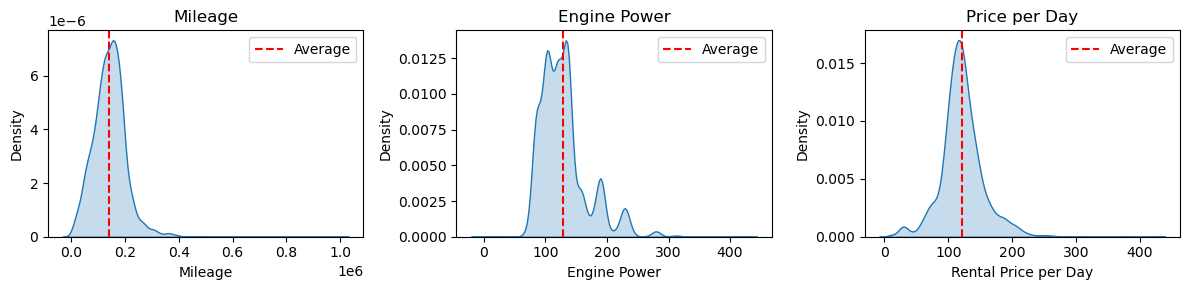

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

sns.kdeplot(data=pricing, x='mileage', fill=True, ax=axes[0])
axes[0].set_title("Mileage")
axes[0].set_xlabel("Mileage")
axes[0].set_ylabel("Density")
axes[0].axvline(pricing.mileage.mean(), color='red', linestyle='--', label='Average')
axes[0].legend()

sns.kdeplot(data=pricing, x='engine_power', fill=True, ax=axes[1])
axes[1].set_title("Engine Power")
axes[1].set_xlabel("Engine Power")
axes[1].set_ylabel("Density")
axes[1].axvline(pricing.engine_power.mean(), color='red', linestyle='--', label='Average')
axes[1].legend()

sns.kdeplot(data=pricing, x='rental_price_per_day', fill=True, ax=axes[2])
axes[2].set_title("Price per Day")
axes[2].set_xlabel("Rental Price per Day")
axes[2].set_ylabel("Density")
axes[2].axvline(pricing.rental_price_per_day.mean(), color='red', linestyle='--', label='Average')
axes[2].legend()

plt.tight_layout()
plt.show()


In [25]:
pricing_average = round(pricing.rental_price_per_day.mean())
pricing_median = round(pricing.rental_price_per_day.median())
print (f"Average price per day: {pricing_average}€, Median price per day: {pricing_median}€.")

average_money_won = round(len(delay_df) * pricing_average)
money_lost = round((2/100) * len(delay_df) * pricing_average)
malus = round(money_lost / ((2/100) * len(delay_df)))

print(f"With the chosen threshold and scope, we would loose {money_lost}€ per day.")
print(f"If we don't want to loose money, we can make a malus of {malus}€ per person delayed per day.")
print(f"Even though it's not reasonable, given the price of the rental per day.")

Average price per day: 121€, Median price per day: 119€.
With the chosen threshold and scope, we would loose 39557€ per day.
If we don't want to loose money, we can make a malus of 121€ per person delayed per day.
Even though it's not reasonable, given the price of the rental per day.


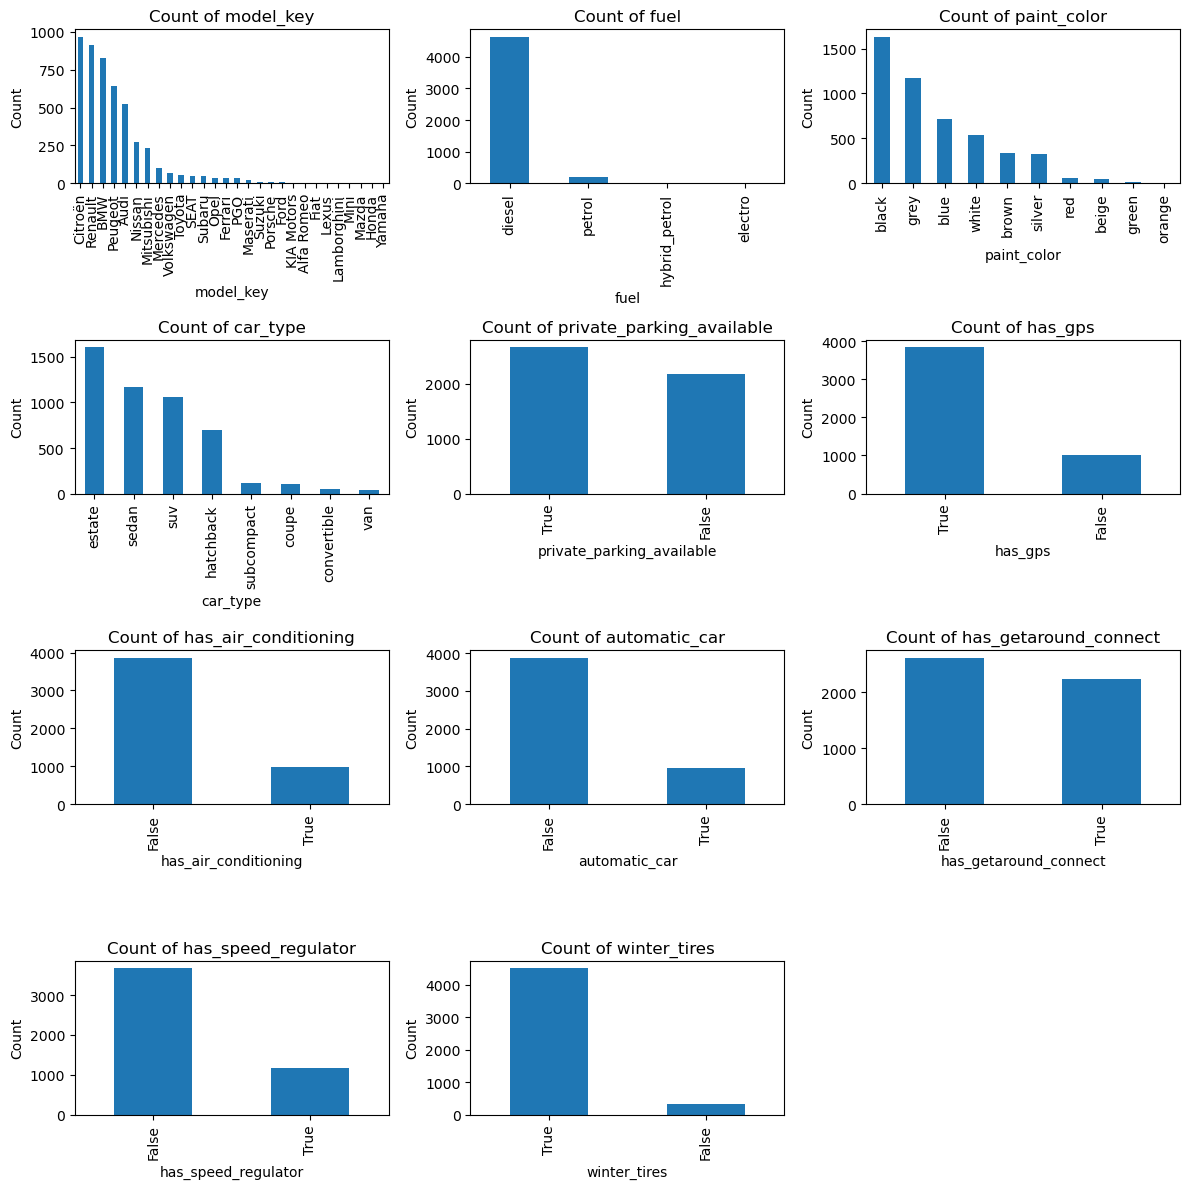

In [22]:
pricing_categorical = pricing.drop(columns=['mileage','engine_power','rental_price_per_day'])
fig, axes = plt.subplots(4, 3, figsize=(12, 4*3))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Iterate over the categorical variables and create bar plots
for i, column in enumerate(pricing_categorical.columns):
    ax = axes[i]
    counts = pricing_categorical[column].value_counts()
    counts.plot(kind='bar', ax=ax)
    ax.set_title(f"Count of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel("Count")

# Hide unused subplots if any
for j in range(11, 12):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [23]:
# Visualize pairwise dependencies
fig = px.scatter_matrix(pricing)
fig.update_layout(
        title = go.layout.Title(text = "Bivariate analysis", x = 0.5), showlegend = False, 
            autosize=False, height = 1200, width = 1200)
fig.show()

# Correlation matrix
corr_matrix = pricing.corr().round(2)

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())
fig.show()

print("The variables that are the most correlated with rental price are mileage (anticorrelated) and engine power.\nExcept for winter tires, all other variables seem important too.\nVariables don't seem correlated otherwise between themselves.")

The variables that are the most correlated with rental price are mileage (anticorrelated) and engine power.
Except for winter tires, all other variables seem important too.
Variables don't seem correlated otherwise between themselves.


In [24]:
correlations_with_target = {}

for column in corr_matrix.columns:
    if column != 'rental_price_per_day':
        correlation = corr_matrix.loc[column, 'rental_price_per_day']
        correlations_with_target[column] = correlation
print(correlations_with_target)

print("""Knowing that we have only 2 numerical variables, and they are both the most correlated with the target,
      we will do feature engineering on those variables. The square value and the logarithm of "mileage" could
      be interesting as it has a negative correlation. For engine_power, we will test the square, the cubed, the
      inverse of it, and then try multiply it with mileage and mileage_squared""")

{'mileage': -0.45, 'engine_power': 0.63, 'private_parking_available': 0.28, 'has_gps': 0.31, 'has_air_conditioning': 0.25, 'automatic_car': 0.42, 'has_getaround_connect': 0.32, 'has_speed_regulator': 0.23, 'winter_tires': 0.02}
Knowing that we have only 2 numerical variables, and they are both the most correlated with the target,
      we will do feature engineering on those variables. The square value and the logarithm of "mileage" could
      be interesting as it has a negative correlation. For engine_power, we will test the square, the cubed, the
      inverse of it, and then try multiply it with mileage and mileage_squared
